# Bibliotheken und Funktionen Importieren

In [296]:
# Bibliotheken importieren
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Daten einlesen und Organisieren

In [297]:
# Daten laden
df = pd.read_csv('../../Data_Processing/whole_cleaned_dataset.csv')

# Features und Zielspalte
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Stratified Folds und K-Folds Erstellen

In [ ]:
# Stratified K-Fold und K-Fold einrichten
#skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
skf = KFold(n_splits=5, shuffle=True, random_state=0)

# Parameter für Grid Search


In [299]:
param_grid = {
    'C':      [0.01, 0.1, 1, 10, 100],   # Best Result = 1
    #'C':    [0.8, 0.9, 1, 1.1, 1,2],     # Best Result = 0.8
    #'C':    [0.5, 0.6, 0.7, 0.8, 0.9],  # Best Result = 0.8
    #'C':    [0.75, 0.775, 0.8, 0.825, 0.85],    # Best Result = 0.825
    'penalty':['l1', 'l2'],
    'solver': ['liblinear'],  # liblinear unterstützt l1 und l2
}


# GridSearchCV mit AUC als Optimierungsziel
grid = GridSearchCV(
    estimator = LogisticRegression(class_weight='balanced', max_iter=1000),
    param_grid = param_grid,
    cv         = skf,
    scoring    = 'roc_auc',
    n_jobs     = -1,        # alle CPUs nutzen
    verbose    = 1
)


# Hyperparameter Tuning

In [300]:
# Grid Search durchführen
grid.fit(X, y)
# Resultate zurückgeben
print("Best Parameters: ", grid.best_params_)
print("Best Mean AUC:   ", grid.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters:  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Mean AUC:    0.8468938021281011


# Best Hyperparameter Model auswählen

In [301]:
best_model = grid.best_estimator_


# Metriken Listen 

In [302]:
# Metriken speichern
precision_list = []
recall_list = []
f1_list = []
auc_list = []

mean_fpr = np.linspace(0, 1, 100)
tprs = []
conf_matrices = []

# Cross Valiation 

In [303]:
# Cross-Validation Schleife
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    """Select best_model for ML to use the best Hyperparameter"""
    #model = LogisticRegression(class_weight='balanced', max_iter=1000)
    best_model.fit(X_train, y_train)

    # Vorhersagen und Wahrscheinlichkeiten
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]  #für die ROC Kurve

    # Metriken berechnen
    precision_list.append(precision_score(y_test, y_pred))
    recall_list.append(recall_score(y_test, y_pred))
    f1_list.append(f1_score(y_test, y_pred))
    auc = roc_auc_score(y_test, y_proba)
    auc_list.append(auc)

    # Confusion Matrix berechnen
    cm = confusion_matrix(y_test, y_pred)
    conf_matrices.append(cm)

    # ROC-Kurve für jeden Fold
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tprs.append(tpr_interp)

    print(f"Fold {fold}: Precision={precision_list[-1]:.2f}, Recall={recall_list[-1]:.2f}, F1={f1_list[-1]:.2f}, AUC={auc:.2f}")

    """
    #Show Confusion Matrix of each Fold
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues", xticklabels=["No Diabetes (0)", "Diabetes (1)"], yticklabels=["No Diabetes (0)", "Diabetes (1)"])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Mean Confusion Matrix')
    plt.show()
    """


Fold 1: Precision=0.59, Recall=0.79, F1=0.67, AUC=0.87
Fold 2: Precision=0.66, Recall=0.68, F1=0.67, AUC=0.83
Fold 3: Precision=0.60, Recall=0.83, F1=0.70, AUC=0.85
Fold 4: Precision=0.66, Recall=0.88, F1=0.75, AUC=0.86
Fold 5: Precision=0.57, Recall=0.71, F1=0.64, AUC=0.82


# ROC Kurven für alle Folds und Mean ROC Kurve


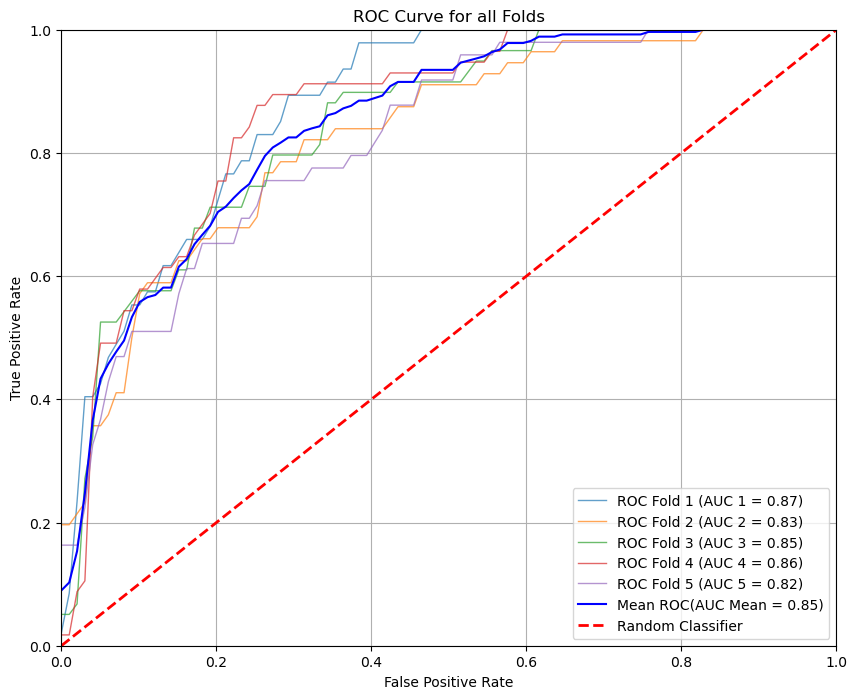

In [304]:
# ROC-Kurven aller Folds plotten
plt.figure(figsize=(10, 8))
for i, tpr in enumerate(tprs):
    plt.plot(mean_fpr, tpr, lw=1, alpha=0.7, label=f"ROC Fold {i + 1} (AUC {i+1} = {auc_list[i]:.2f})")

mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
mean_auc = np.mean(auc_list)
plt.plot(mean_fpr, mean_tpr, color='b', label=f"Mean ROC(AUC Mean = {mean_auc:.2f})", lw=1.5)                            # Die Mean ROC Kurve
#plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 Std. Dev.')      #Der Std Bereich (Grau)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', lw=2, label='Random Classifier')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for all Folds')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# NUR Mean ROC Kurve

In [305]:
"""
# Nur Durchschnittliche ROC-Kurve zeichnen
mean_tpr = np.mean(tprs, axis=0)
mean_auc = np.mean(auc_list)

plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, label=f'Mean ROC (AUC = {mean_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--',color='r', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Stratified K-Fold ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()
"""

'\n# Nur Durchschnittliche ROC-Kurve zeichnen\nmean_tpr = np.mean(tprs, axis=0)\nmean_auc = np.mean(auc_list)\n\nplt.figure(figsize=(8, 6))\nplt.plot(mean_fpr, mean_tpr, label=f\'Mean ROC (AUC = {mean_auc:.2f})\', color=\'blue\')\nplt.plot([0, 1], [0, 1], linestyle=\'--\',color=\'r\', label=\'Random Classifier\')\nplt.xlabel(\'False Positive Rate\')\nplt.ylabel(\'True Positive Rate\')\nplt.title(\'Stratified K-Fold ROC Curve\')\nplt.legend(loc="lower right")\nplt.grid()\nplt.show()\n'

# Feature Importance  

In [306]:
feature_importance = pd.Series(best_model.coef_[0], index=X_train.columns)


"""
# Print Feature Importance
print(feature_importance)
print("")
"""

#Gib die Feature Importance in Absteigender Reihenfolge zurück
feature_importance = feature_importance.sort_values(ascending=False)
print(feature_importance)


Glucose                     0.991942
BMI                         0.420498
Age                         0.368223
DiabetesPedigreeFunction    0.237883
SkinThickness               0.152624
Pregnancies                 0.129765
Insulin                     0.053236
BloodPressure               0.000000
dtype: float64


# Mean Confusion Matrix 

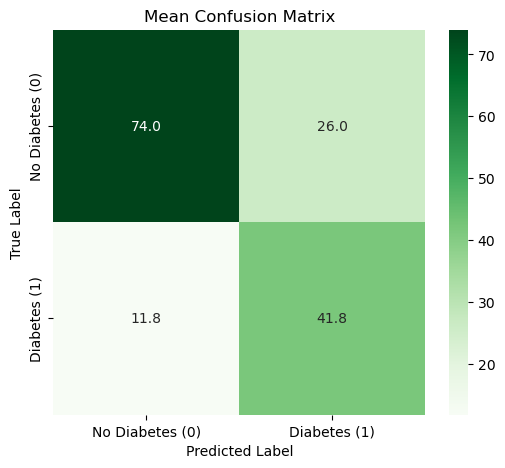

In [307]:
# Mean Confusion Matrix berechnen und plotten
mean_conf_matrix = np.mean(conf_matrices, axis=0)

plt.figure(figsize=(6, 5))
sns.heatmap(mean_conf_matrix, annot=True, fmt=".1f", cmap="Greens", 
            xticklabels=["No Diabetes (0)", "Diabetes (1)"],
            yticklabels=["No Diabetes (0)", "Diabetes (1)"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Mean Confusion Matrix')
plt.show()

# Durchschnitt und Standardabweichung der Metriken

In [308]:
# Zusammenfassung der Metriken
metrics = {
    "Precision": (np.mean(precision_list), np.std(precision_list)),
    "Recall": (np.mean(recall_list), np.std(recall_list)),
    "F1-Score": (np.mean(f1_list), np.std(f1_list)),
    "AUC": (np.mean(auc_list), np.std(auc_list))
}

print("=== Durchschnitt und Standardabweichung der Metriken ===")
for metric, (mean, std) in metrics.items():
    print(f"{metric}: Mittelwert = {mean:.3f}, Standardabweichung = {std:.3f}")
    print(f"{metric}: {mean:.3f} ± {std:.3f} ")
    print("")


=== Durchschnitt und Standardabweichung der Metriken ===
Precision: Mittelwert = 0.616, Standardabweichung = 0.035
Precision: 0.616 ± 0.035 

Recall: Mittelwert = 0.778, Standardabweichung = 0.073
Recall: 0.778 ± 0.073 

F1-Score: Mittelwert = 0.686, Standardabweichung = 0.039
F1-Score: 0.686 ± 0.039 

AUC: Mittelwert = 0.847, Standardabweichung = 0.020
AUC: 0.847 ± 0.020 

